In [2]:
# Importing neccessary packages and libraries

# For calculating time
import time

# For image related tasks
from PIL import Image

# For array related tasks
import numpy as np

# For using backend utilities
from keras import backend

# For using the keras model class
from keras.models import Model

# For importing vgg16 model
from keras.applications.vgg16 import VGG16

# To solve the optimization problem
from scipy.optimize import fmin_l_bfgs_b

In [3]:
# Setting common height and width for the style, content and output image
# The style image has dimensions : 468*600 and the content image has dimensions : 960*498
# So for the output I have choose final image size as 960*600 (based on style and content image dim)

height = 600
width = 960

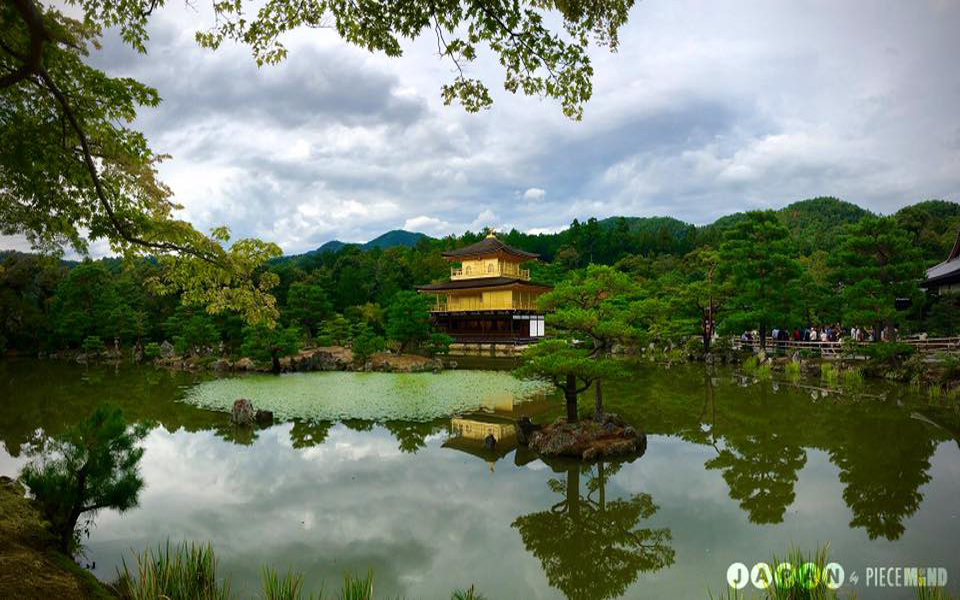

In [4]:
# Opening and resizing content image with defined dimensions

content_image = Image.open('japanese_garden.jpg')
content_image = content_image.resize((width, height))
content_image

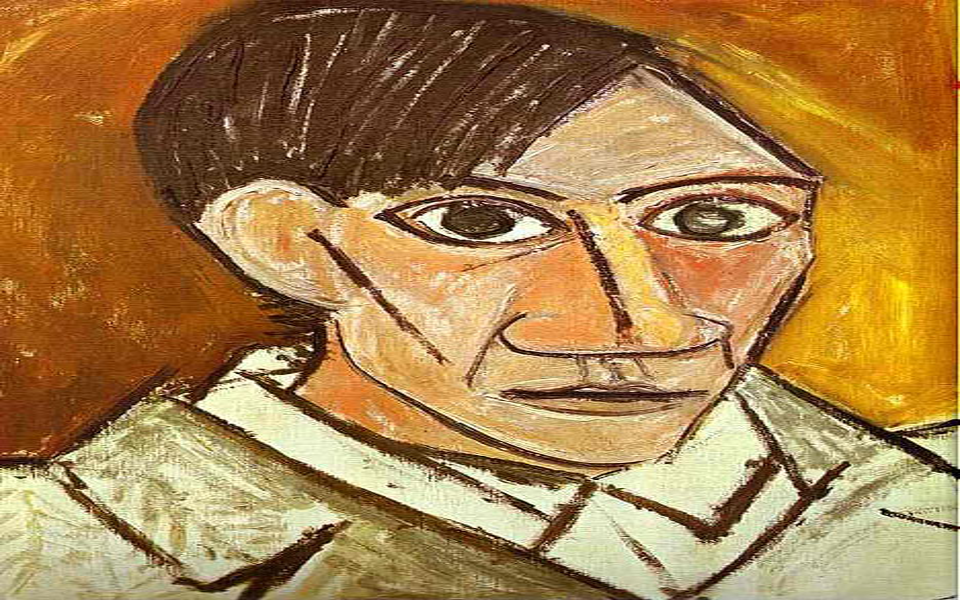

In [5]:
# Opening and resizing style image with defined dimensions

style_image = Image.open('picasso_selfportrait.jpg')
style_image = style_image.resize((width, height))
style_image

In [6]:
# Converting content and style image into a form suitable for numerical processing
# Shape before converting the form of images : (height, width, no. of channels) (For RGB the no. of channels = 3)
# Shape after converting the form of images : (1, height, width, no. of channels)

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print("Content array shape : ", content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print("Style image shape : ", style_array.shape)

Content array shape :  (1, 600, 960, 3)
Style image shape :  (1, 600, 960, 3)


In [7]:
# As stated in the reaserch paper that introduces VGG model we need to perform some transformations
# 1. We need to subtract the mean RGB value from each pixel
# 2. We need to cnvert our multidimensional araay from RGB to BGR
# We are converting it into BGR format because in the research paper they have used this BGR ordering 

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [8]:
# Now that we have performed the neccessary transformations

# Creating a varible instance for content array
content_image = backend.variable(content_array)

# Creating a variable instance for style array
style_image = backend.variable(style_array)

# Introducing placeholder variable for the combination image
combination_image = backend.placeholder((1, height, width, 3))

In [9]:
# Concatinating these image data into a single tensor
# This tensor is suitable to process by VGG16 model

input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

In [10]:
# Initializing VGG16 model wihtout the top layers (i.e. Fully connected layers) 

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [11]:
# Listing the layers of VGG16 into a list for the furthur use 

layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 600, 960, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 600, 960, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 600, 960, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 300, 480, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 300, 480, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 300, 480, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 150, 240, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 150, 240, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 150, 240, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 150, 240, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 75, 120, 256) dtype=float32>,
 'block4_conv1': <

In [12]:
# Initializing some scalar weights
# I have done some experimenting by changing them and I have stated  the weights that gave the best output according to me
# You can find the results of my experimenting in Experiment folder
# In that folder you can see the output images that I got by changing the scalar values

content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [13]:
# Initializing the total loss as 0

loss = backend.variable(0.)

In [14]:
def content_loss(content, combination):
    """
    This function calculates the content loss.
    Content loss = Euclidean dist between feature representations of the content and combination images.
    """
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

# Adding the obtained loss into total loss
loss = loss + (content_weight * content_loss(content_image_features, combination_features))

In [15]:
def gram_matrix(x):
    """
    This function calculates the Gram matrix.
    We are using Gram matrix because we need something which does not care about the specific presence 
    or location of the detected features within an image and the Gram matrix affords this.
    """
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [16]:
def style_loss(style, combination):
    """
    This function calculates the Style loss.
    Style loss = vector norm of the difference between the Gram matrices of the style and combination images.
    """
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


# Choosing the feature layers for calculating Style loss
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']


# Calculating Style loss and adding it into the final loss.
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [17]:
def total_variation_loss(x):
    """
    Results obtained from the Style and content loss are quite noisy.
    So we are adding a new term total_variation_loss which encourages spatial smoothness.
    """
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

# Adding total_variation_loss into total Loss
loss += total_variation_weight * total_variation_loss(combination_image)

In [18]:
# Defining the gradients

grads = backend.gradients(loss, combination_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    """
    This function calculates loss and gradient.
    """
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

# Defining the class
class Evaluator(object):
    """
    This class computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads.
    """
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# Calling the Evaluator class
evaluator = Evaluator()

In [20]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

# Setting total number of epochs
epochs = 10

for i in range(epochs):
    print('Starting iteration : ', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value : ', min_val)
    end_time = time.time()
    print('Completed Iteration %d in %d seconds' % (i, end_time - start_time))

Starting iteration :  0
Current loss value :  114197760000.0
Completed Iteration 0 in 99 seconds
Starting iteration :  1
Current loss value :  59101840000.0
Completed Iteration 1 in 66 seconds
Starting iteration :  2
Current loss value :  47512840000.0
Completed Iteration 2 in 66 seconds
Starting iteration :  3
Current loss value :  42365680000.0
Completed Iteration 3 in 66 seconds
Starting iteration :  4
Current loss value :  40006680000.0
Completed Iteration 4 in 67 seconds
Starting iteration :  5
Current loss value :  38361813000.0
Completed Iteration 5 in 74 seconds
Starting iteration :  6
Current loss value :  37459546000.0
Completed Iteration 6 in 75 seconds
Starting iteration :  7
Current loss value :  36899545000.0
Completed Iteration 7 in 73 seconds
Starting iteration :  8
Current loss value :  36500644000.0
Completed Iteration 8 in 66 seconds
Starting iteration :  9
Current loss value :  36259525000.0
Completed Iteration 9 in 68 seconds


# Observations

- Here after 8th iteration the loss was not decreasing much. 
- So I have only run it for the 10 epochs.

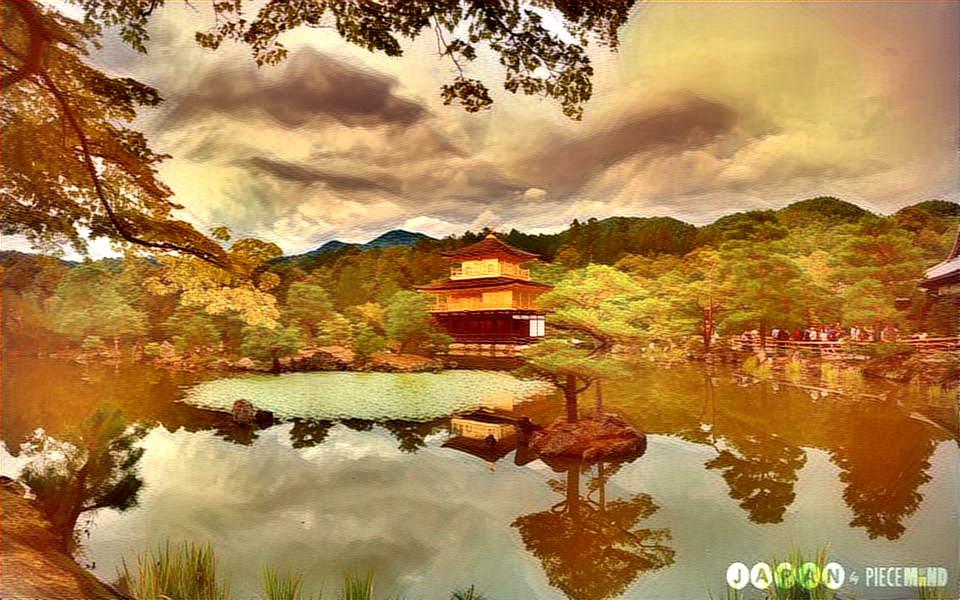

In [21]:
# Converting into the Image From

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

# Showing the output image
Image.fromarray(x)

In [22]:
import imageio

# Saving the output image as Combination Image
imageio.imwrite("combinaton_image.png", x)

<h1><font color = red> References </font></h1>

- To understand the concept and write code for this problem I have taken help from this resources.
<br><br>

1 -  Neural Style Transfer: Creating Art with Deep Learning using tf.keras and eager execution<br>
Link - https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398
<br><br>

2 - Neural style transfer<br>
Link - https://www.tensorflow.org/tutorials/generative/style_transfer
<br><br>

3 - A Neural Algorithm of Artistic Style Research paper <br>
Link - https://arxiv.org/abs/1508.06576
<br><br>

4 - Artistic Style Transfer with Convolutional Neural Network <br>
Link - https://medium.com/data-science-group-iitr/artistic-style-transfer-with-convolutional-neural-network-7ce2476039fd
<br><br>

5 - Perceptual Losses for Real-Time Style Transfer and Super-Resolution Research paper <br>
Link - https://arxiv.org/abs/1603.08155

<h1> <font color=blue> Procedure Followed </font></h1>

- So as I read the problem statement I knew about CNN, Depp Learning, and computer vision but I did not know specifically about the style transfer.
- By looking at what this Style transfer is I was very excited to learn and work on it.
- So I started by reading some articles about the Style transfer then after knowing it I read the research paper that introduces the Style transfer using CNN.
- I learned a lot about how we can use the pretrained models like VGG16, VGG19 to solve this problem.
- I was aware about the tranfer learning so I have also tried other predefined models like Densenet, etc but they took significantly more time than VGG16 and the results were also poor as compare to VGG results.
- So at the end I choose to stick with the VGG model.
- In deep learning one of the most important thing is to choose the right hyperparameters. 
- After some experimenting, I selected the weights that gave the best output according to me.